In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ls.config.loader import load_config
import IPython.display as ipd
import torch

In [3]:
# --- 1. load config ---
cfg = load_config("../configs/config.yaml")

print(cfg.keys())

dict_keys(['seed', 'dataset', 'audio', 'models', 'training', 'mlflow'])


### ICBHI Dataloader using only test set as the validation set

In [4]:
# # Regular training
from ls.data.dataloaders import build_dataloaders


train_loader, test_loader = build_dataloaders(cfg.dataset, cfg.audio)

[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)
[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)


/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https:/

[ICBHI] Extracted 4142 respiratory cycles from 539 recordings
[ICBHI] Input spectrogram shape: (997, 128, 1)
[ICBHI] 4142 cycles (base cycles only, aug handled dynamically)
  Class 0: 2063 (49.8%)
  Class 1: 1215 (29.3%)
  Class 2: 501 (12.1%)
  Class 3: 363 (8.8%)
[ICBHI] Active waveform augmentations: Loudness, VTLP
[ICBHI] Active spectrogram augmentations: SpecAugment
[ICBHI] Expected P(augmented) ≈ 0.43 (~1793/4142 per epoch)


/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https:/

[ICBHI] Extracted 2756 respiratory cycles from 381 recordings
[ICBHI] Input spectrogram shape: (997, 128, 1)
[ICBHI] 2756 cycles (base cycles only, aug handled dynamically)
  Class 0: 1579 (57.3%)
  Class 1: 649 (23.5%)
  Class 2: 385 (14.0%)
  Class 3: 143 (5.2%)
[ICBHI] No waveform augmentations
[ICBHI] No spectrogram augmentations


In [5]:
for batch in train_loader:
    print(batch["input_values"].shape, batch["label"].shape, batch["filename"])
    break

torch.Size([8, 1, 128, 1024]) torch.Size([8]) ['192_2b2_Ar_mc_LittC2SE', '135_2b3_Al_mc_LittC2SE', '221_2b3_Lr_mc_LittC2SE', '130_2b3_Ll_mc_AKGC417L', '218_1b1_Ar_sc_Meditron', '107_2b3_Pl_mc_AKGC417L', '191_2b1_Pl_mc_LittC2SE', '193_7b3_Pl_mc_AKGC417L']


Inspecting sample index 1 in the batch
Keys: dict_keys(['input_values', 'labels', 'audio', 'label', 'filename', 'cycle_index', 'duration', 'start_time', 'end_time', 'crackle', 'wheeze', 'fbank', 'aug_audio', 'aug_fbank'])
Filename: 135_2b3_Al_mc_LittC2SE
Cycle index: tensor(6)
Label: tensor(0)
Duration: tensor(2.3000, dtype=torch.float64)
Start-End: tensor(15.1640, dtype=torch.float64) - tensor(17.4640, dtype=torch.float64)
Crackle/Wheeze: tensor(0) tensor(0)
Waveform shape: torch.Size([1, 160000])
Mel image shape: torch.Size([1, 128, 1024])


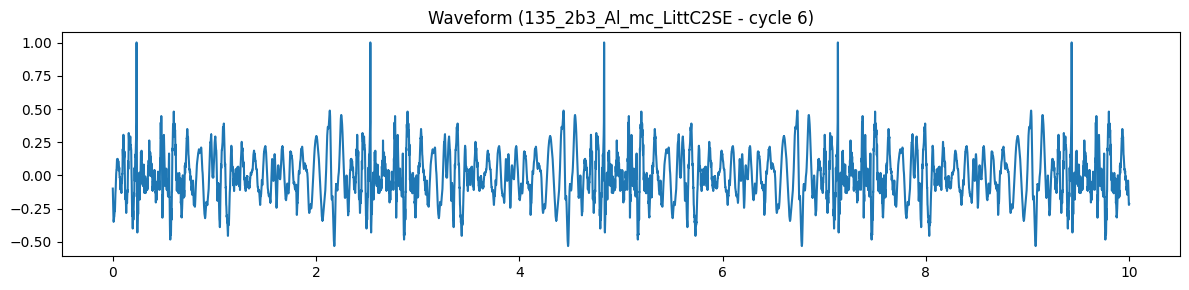

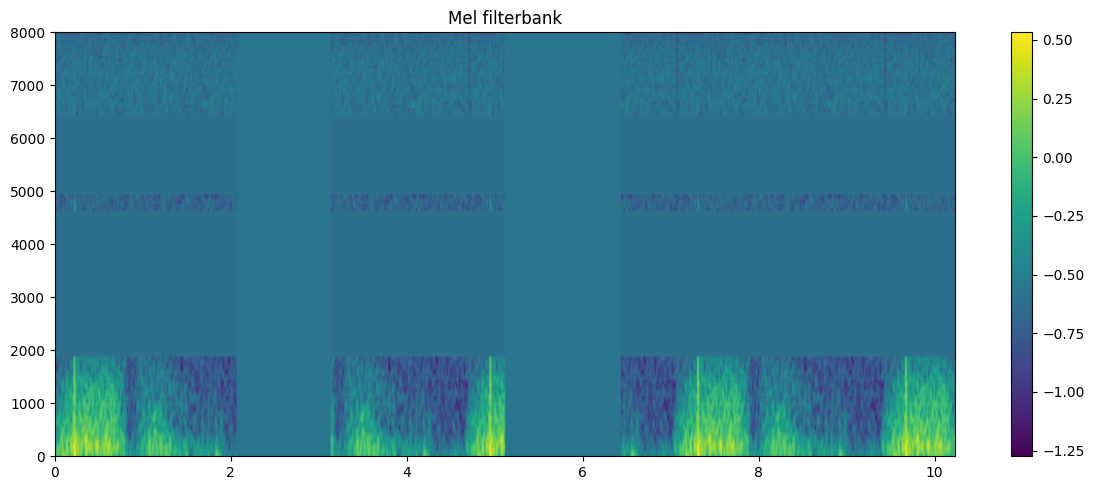

In [6]:
# --- Inspect one sample ---
idx = torch.randint(cfg.dataset.batch_size, (1,)).item()
print(f"Inspecting sample index {idx} in the batch")
print("Keys:", batch.keys())
print("Filename:", batch["filename"][idx])
print("Cycle index:", batch["cycle_index"][idx])
print("Label:", batch["label"][idx])
print("Duration:", batch["duration"][idx])
print("Start-End:", batch["start_time"][idx], "-", batch["end_time"][idx])
print("Crackle/Wheeze:", batch["crackle"][idx], batch["wheeze"][idx])
# print(sample["aug_audio"].shape, sample["aug_fbank"].shape, sample["audio"].shape, sample["fbank"].shape)
print("Waveform shape:", batch["audio"][idx].shape)
print("Mel image shape:", batch["input_values"][idx].shape)
# print(f"Waveform augmented: {not tensors_equal(batch['audio'][idx].view(-1), batch['aug_audio'][idx].view(-1))}")
# print(f"Mel augmented: {not tensors_equal(batch['fbank'][idx].view(-1), batch['aug_fbank'][idx].view(-1))}")

# --- 4. Plot waveform ---
waveform = batch["audio"][idx].squeeze().numpy()
plt.figure(figsize=(12, 3))
plt.plot(np.arange(waveform.shape[0]) / cfg.audio.sample_rate, waveform)
plt.title(f"Waveform ({batch['filename'][idx]} - cycle {batch['cycle_index'][idx]})")
plt.tight_layout()
plt.show()

# --- 5. Plot mel spectrogram ---
mel = batch["input_values"][idx].squeeze(0) # [freq, time] for imshow
freq_axis = np.linspace(0, cfg.audio.sample_rate // 2, mel.shape[0])
time_axis = np.arange(mel.shape[1]) * cfg.audio.frame_shift / 1000  # in seconds
plt.figure(figsize=(12, 5))
plt.imshow(mel, origin="lower", aspect="auto", extent=[0, time_axis[-1], 0, freq_axis[-1]], cmap="viridis")
plt.title("Mel filterbank")
plt.colorbar()
plt.tight_layout()
plt.show()

ipd.Audio(waveform, rate=cfg.audio.sample_rate)  # listen to the sound

In [12]:
from ls.models.ast import ASTModel

# With AudioSet pretraining
ast_mdl = ASTModel(
    label_dim=4,
    fstride=10,
    tstride=10,
    input_fdim=128,
    input_tdim=1024,
    imagenet_pretrain=True,
    audioset_pretrain=True,
    audioset_ckpt_path=cfg.models.ast.audioset_ckpt_path,
    model_size='base384',
    verbose=True,
    dropout_p=0.3
)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
Loading AudioSet pretrained model from /home/AIoT04/Dev/pretrained_models/audioset_10_10_0.4593.pth
No mismatch for key: v.cls_token
No mlp_head weights loaded from AudioSet checkpoint.
No mismatch for key: v.pos_embed
No mlp_head weights loaded from AudioSet checkpoint.
No mismatch for key: v.dist_token
No mlp_head weights loaded from AudioSet checkpoint.
No mismatch for key: v.patch_embed.proj.weight
No mlp_head weights loaded from AudioSet checkpoint.
No mismatch for key: v.patch_embed.proj.bias
No mlp_head weights loaded from AudioSet checkpoint.
No mismatch for key: v.blocks.0.norm1.weight
No mlp_head weights loaded from AudioSet checkpoint.
No mismatch for key: v.blocks.0.norm1.bias
No mlp_head weights loaded from AudioSet checkpoint.
No mismatch for key: v.blocks.0.attn.qkv.weight
No mlp_head weights loaded from AudioSet checkpoint.
No mismatch for key: v.blocks.0.attn.qkv.bias

In [13]:
print(ast_mdl)

ASTModel(
  (reg_dropout): Dropout(p=0.3, inplace=False)
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=F

In [1]:
class_counts = train_loader.dataset.class_counts
total = sum(class_counts)
class_weights = torch.tensor([total/count for count in class_counts])
class_weights = class_weights / class_weights.sum() # * len(class_weights)
class_weights

NameError: name 'train_loader' is not defined

In [9]:
total = sum(class_counts)
alpha = torch.tensor([total/count for count in class_counts])
alpha = alpha / alpha.sum() * len(alpha)
alpha

tensor([0.3200, 0.5434, 1.3178, 1.8188], dtype=torch.float64)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean', task_type='binary', num_classes=None):
        """
        Unified Focal Loss class for binary, multi-class, and multi-label classification tasks.
        :param gamma: Focusing parameter, controls the strength of the modulating factor (1 - p_t)^gamma
        :param alpha: Balancing factor, can be a scalar or a tensor for class-wise weights. If None, no class balancing is used.
        :param reduction: Specifies the reduction method: 'none' | 'mean' | 'sum'
        :param task_type: Specifies the type of task: 'binary', 'multi-class', or 'multi-label'
        :param num_classes: Number of classes (only required for multi-class classification)
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.task_type = task_type
        self.num_classes = num_classes

        # Handle alpha for class balancing in multi-class tasks
        if task_type == 'multi-class' and alpha is not None and isinstance(alpha, (list, torch.Tensor)):
            assert num_classes is not None, "num_classes must be specified for multi-class classification"
            if isinstance(alpha, list):
                self.alpha = torch.Tensor(alpha)
            else:
                self.alpha = alpha

    def forward(self, inputs, targets):
        """
        Forward pass to compute the Focal Loss based on the specified task type.
        :param inputs: Predictions (logits) from the model.
                       Shape:
                         - binary/multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size, num_classes)
        :param targets: Ground truth labels.
                        Shape:
                         - binary: (batch_size,)
                         - multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size,)
        """
        if self.task_type == 'binary':
            return self.binary_focal_loss(inputs, targets)
        elif self.task_type == 'multi-class':
            return self.multi_class_focal_loss(inputs, targets)
        elif self.task_type == 'multi-label':
            return self.multi_label_focal_loss(inputs, targets)
        else:
            raise ValueError(
                f"Unsupported task_type '{self.task_type}'. Use 'binary', 'multi-class', or 'multi-label'.")

    def binary_focal_loss(self, inputs, targets):
        """ Focal loss for binary classification. """
        probs = torch.sigmoid(inputs)
        targets = targets.float()

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weighting
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_class_focal_loss(self, inputs, targets):
        """ Focal loss for multi-class classification. """
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)

        # Convert logits to probabilities with softmax
        probs = F.softmax(inputs, dim=1)

        # One-hot encode the targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Compute cross-entropy for each class
        ce_loss = -targets_one_hot * torch.log(probs)

        # Compute focal weight
        p_t = torch.sum(probs * targets_one_hot, dim=1)  # p_t for each sample
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided (per-class weighting)
        if self.alpha is not None:
            alpha_t = alpha.gather(0, targets)
            ce_loss = alpha_t.unsqueeze(1) * ce_loss

        # Apply focal loss weight
        loss = focal_weight.unsqueeze(1) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_label_focal_loss(self, inputs, targets):
        """ Focal loss for multi-label classification. """
        probs = torch.sigmoid(inputs)

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weight
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [15]:
focal_loss_crit = FocalLoss(
    gamma=2.0,
    alpha=alpha,
    task_type='multi-class',
    num_classes=4
)

loss = focal_loss_crit(ast_mdl(batch["input_values"]), batch["label"])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
labels = np.array([s['label'] for s  in train_loader.dataset.samples])
n_classes = len(train_loader.dataset.class_counts)
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(n_classes),
    y=labels
)
print(f"Using computed class weights: {weights}", weights.dtype)
weights = weights / weights.sum() # normalize to sum to 1
weights * len(weights)

In [ ]:
# Using computed class weights: [0.50193892 0.85226337 2.06686627 2.85261708] float64
# [INFO] Using dynamically computed class weights for Focal Loss: [0.07999999821186066, 0.13600000739097595, 0.32899999618530273, 0.45500001311302185]"

In [ ]:
epochs = cfg.training.epochs
initial_wd = float(cfg.training.optimizer.weight_decay)
final_wd = float(cfg.training.optimizer.final_weight_decay)
cfg.training.optimizer.lr = 3e-4
lr = float(cfg.training.optimizer.lr)

epochs, initial_wd, final_wd, lr

In [ ]:
cfg.training.scheduler.type = "cosine_warmup" # options: none, cosine, cosine_warmup, reduce_on_plateau, cosine_warmup_restarts

In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(
    ast_mdl.parameters(),
    lr=lr,
    weight_decay=initial_wd,
)

In [ ]:
from ls.engine.scheduler import build_scheduler

scheduler = build_scheduler(cfg.training.scheduler, cfg.training.epochs, optimizer)

In [ ]:
optimizer.param_groups[0]["lr"]

In [ ]:
cfg.training.scheduler.start_linear_warmup, cfg.training.scheduler.end_linear_warmup

In [ ]:
cfg.training.lr

In [ ]:
lrs = [] # optimizer.param_groups[0]["lr"]

for epoch in range(cfg.training.epochs):
    optimizer.step()
    scheduler.step()              # update LR according to schedule
    current_lr = optimizer.param_groups[0]['lr']
    if epoch < 10:
        print(current_lr)
    lrs.append(current_lr)

# --------------------------------------------------------
# 3. Plot the learning rate evolution
# --------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(range(cfg.training.epochs), lrs, label=scheduler.__class__.__name__, lw=2)
plt.hlines(1e-8, 0, cfg.training.epochs, colors="gray", linestyles="--", label="Lowest LR")
plt.xlabel("Step (epoch or iteration)")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule in PyTorch")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


In [ ]:
import torch

sd = torch.load('/home/AIoT04/Dev/pretrained_models/audioset_10_10_0.4593.pth', map_location='cpu')
print("Checkpoint keys (first 10):")
for i, k in enumerate(list(sd.keys())):
    print(f"  {k}: {sd[k].shape if hasattr(sd[k], 'shape') else type(sd[k])}")
    
print(f"\nTotal keys: {len(sd.keys())}")

In [ ]:
# # Without AudioSet (ImageNet only or from scratch)
# model = ASTModel(
#     label_dim=4,
#     imagenet_pretrain=True,
#     audioset_pretrain=False,
#     model_size='base384'
# )

In [ ]:
from ls.models.ast import ASTModel

In [ ]:
ast_mdl = ASTModel(
    input_tdim=cfg.dataset.w,
    model_size='base384',
    verbose=True,
    backbone_only=False,
    dropout_p=0.0,
    audioset_pretrain=True,
    audioset_ckpt_path="/home/AIoT04/Dev/pretrained_models/audioset_10_10_0.4593.pth"
)

In [ ]:
print(ast_mdl)

In [ ]:
print(batch["input_values"].shape) # (B, 1, freq, time)

In [ ]:
logits = ast_mdl(batch["input_values"])
print("Logits shape:", logits.shape)  # [B, num_classes]

## Or Using Hugging Face's

In [ ]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification
from datasets import load_dataset
import torch

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

print(model)
print(feature_extractor)